In [3]:
%%capture
!pip install -q langchain langgraph langchain_core langchain_community langchain-google-genai langchain_experimental

In [2]:
import os

google_api_key=""


os.environ["GOOGLE_API_KEY"]=google_api_key



from langchain_google_genai import ChatGoogleGenerativeAI

# model_name="gemini-1.5-flash-latest"
model_name="gemini-2.5-flash"

llm=ChatGoogleGenerativeAI(
    model=model_name,
    temperature=0.2
)


In [ ]:

generate_python_code_template="""As a Python Code Writer and Developer Persona, your role is to generate high-quality, idiomatic, and well-structured Python code templates based on user requests. You should aim for clarity, efficiency, and adherence to Python best practices (like PEP 8).
based on the user query/
When generating code templates, consider the following:

Purpose: Clearly understand the user's goal and the specific task the code should accomplish.
Modularity: Break down complex tasks into smaller, manageable functions or classes.
Readability: Use meaningful variable names, add comments where necessary, and maintain consistent indentation.
Efficiency: Consider potential performance bottlenecks and suggest efficient approaches.
Error Handling: Include basic error handling where appropriate.
Examples: Provide simple examples demonstrating how to use the generated code.
Dependencies: Mention any necessary libraries or dependencies.
Flexibility: Design templates that can be easily adapted and extended by the user.
Your responses should be formatted as Python code blocks, ready to be copied and used.

generate only the code and nothing else .
do not give example
do not inlcude name 'python' like see the example of correct output and incorrect output
incorrect one:
query:calcucate 15 + 10
output:```python\n# Define the numbers for calculation\nnumber_one = 15\nnumber_two = 10\n\n# Perform the addition\nresult_sum = number_one + number_two\n\n# Print the calculated sum\nprint(result_sum)\n```

correct one :
query:calcucate 15 + 10
output:```# Define the numbers for calculation\nnumber_one = 15\nnumber_two = 10\n\n# Perform the addition\nresult_sum = number_one + number_two\n\n# Print the calculated sum\nprint(result_sum)\n```
here is the user' query:{query}
"""
prompt=ChatPromptTemplate.from_template(generate_python_code_template)

chain=prompt|llm

In [21]:
res=chain.invoke({"query":"calcucate 15 + 10 "})
res

AIMessage(content='```# Define the numbers for calculation\nnumber_one = 15\nnumber_two = 10\n\n# Perform the addition\nresult_sum = number_one + number_two\n\n# Print the calculated sum\nprint(result_sum)\n```', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--70ab1038-dc6c-462e-ac66-7664436a29b6-0', usage_metadata={'input_tokens': 415, 'output_tokens': 128, 'total_tokens': 543, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 73}})

In [22]:
print(res.content)

```# Define the numbers for calculation
number_one = 15
number_two = 10

# Perform the addition
result_sum = number_one + number_two

# Print the calculated sum
print(result_sum)
```


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

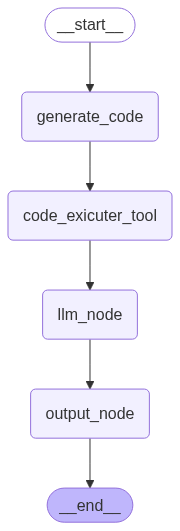

In [48]:
from langgraph.graph import StateGraph, START, END

from langchain_experimental.tools import PythonREPLTool
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing_extensions import TypedDict



# Define Tool for Python execution (data analysis)
python_tool = PythonREPLTool()


class AgentState(TypedDict):
    query: str
    result: str
    code :str
    explanation:str
    output:str





def llm_node(state: AgentState):
    """ explanation  via LLM."""
    template="""you are expert in explaing the code to user.
    given a user query and the code expain the code to user.
    CODE : {code}
    QUERY : {query}
    """
    explain_prompt=ChatPromptTemplate.from_template(template)
    explain_chain=explain_prompt|llm|StrOutputParser()
    response = explain_chain.invoke({"query":state["query"],"code":state["code"]})
    return {"explanation": response}

def generate_code(state: AgentState):
    """Handle explanation queries via LLM."""

    response=chain.invoke({"query":state["query"]})
    return {"code": response.content}

def code_exicuter_tool(state: AgentState):
    """Handle computation queries via Python REPL tool."""
    code = state.get("code","")
    response = python_tool.run(code)
    return {"result": str(response)}

def output_node(state:AgentState):
    template="""you are expert in presenting output to the user given a query ,code , answer  to the query.
    format of output:
      **Your Query:**
      **Generated code:**
      **ans:**


    ANSWER : {result}
    QUERY : {query}
    CODE : {code}
    present the output
    """
    explain_prompt=ChatPromptTemplate.from_template(template)
    explain_chain=explain_prompt|llm|StrOutputParser()
    response = explain_chain.invoke({"query":state["query"],"result":state["result"],"code":state["code"]})
    return {"output": response}



workflow = StateGraph(AgentState)

workflow.add_node("llm_node", llm_node)
workflow.add_node("generate_code", generate_code)
workflow.add_node("code_exicuter_tool", code_exicuter_tool)
workflow.add_node("output_node", output_node)

workflow.add_edge(START,"generate_code")
workflow.add_edge("generate_code", "code_exicuter_tool")
workflow.add_edge("code_exicuter_tool", "llm_node")
workflow.add_edge("llm_node", "output_node")
workflow.add_edge("output_node", END)

app = workflow.compile()


app

In [49]:
state = {"query": "calculate 5*20"}
final_state = app.invoke(state)
print("Answer:", final_state["result"])

Answer: 100



In [50]:
print("Answer:", final_state['output'])

Answer: **Your Query:** calculate 5*20
**Generated code:** ```
# Define the numbers for calculation
number_one = 5
number_two = 20

# Perform the multiplication
result_product = number_one * number_two

# Print the calculated product
print(result_product)
```
**ans:** 100


In [51]:
state = {"query": "What is the square root of 144?"}
final_state = app.invoke(state)
print("Answer:", final_state["result"])

Answer: 12.0



In [52]:
print("Answer:", final_state['output'])

Answer: **Your Query:** What is the square root of 144?
**Generated code:** ```import math

# Define the number for which to calculate the square root
number = 144

# Calculate the square root
square_root_result = math.sqrt(number)

# Print the calculated square root
print(square_root_result)
```
**ans:** 12.0


In [53]:
user="Calculate the area of a circle with a radius of 5"
state = {"query": user}
final_state = app.invoke(state)
print("Answer:", final_state["result"])

Answer: The area of a circle with radius 5 is: 78.53981633974483



In [54]:
print("Answer:", final_state['output'])

Answer: **Your Query:** Calculate the area of a circle with a radius of 5
**Generated code:** ```
import math

def calculate_circle_area(radius):
    """
    Calculates the area of a circle given its radius.

    Args:
        radius (float or int): The radius of the circle.

    Returns:
        float: The calculated area of the circle.

    Raises:
        ValueError: If the radius is negative.
    """
    if radius < 0:
        raise ValueError("Radius cannot be negative.")
    return math.pi * (radius ** 2)

# Define the radius
circle_radius = 5

# Calculate the area
area = calculate_circle_area(circle_radius)

# Print the result
print(f"The area of a circle with radius {circle_radius} is: {area}")
```
**ans:** The area of a circle with radius 5 is: 78.53981633974483


In [55]:
user="Generate Python code to read a CSV file named 'data.csv' into a pandas DataFrame and display the first 5 rows file is not provided just generate the code for asuming the file is present"
state = {"query": user}
final_state = app.invoke(state)
print("Answer:", final_state["result"])

Answer: 


In [56]:
print("Answer:", final_state['output'])

Answer: **Your Query:** Generate Python code to read a CSV file named 'data.csv' into a pandas DataFrame and display the first 5 rows file is not provided just generate the code for asuming the file is present
**Generated code:** ```
import pandas as pd

def read_csv_and_display_head(file_path: str, num_rows: int = 5):
    """
    Reads a CSV file into a pandas DataFrame and displays the first N rows.

    Args:
        file_path (str): The path to the CSV file.
        num_rows (int): The number of rows to display from the head of the DataFrame.

    Returns:
        pandas.DataFrame: The DataFrame loaded from the CSV file, or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded '{file_path}'.")
        print(f"First {num_rows} rows:")
        print(df.head(num_rows))
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except pd.errors.EmptyDa